In [ ]:
# only necessary for google colab! to load models into session
!git clone https://github.com/ProProPrin/5licer
!mv 5licer/* ./

In [ ]:
!pip install tetgen
!pip install pyvista
!pip install scipy
!pip install open3d
!pip install pygcode
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.1 MB/s eta 0:00:00
  Created wheel for euclid3: filename=euclid3-0.1-py3-none-any.whl size=13228 sha256=221544bf5597639c41af55dc7c5e43e029f91abe168e8004ab601d46df4be786
  Stored in directory: /root/.cache/pip/wheels/38/33/68/7f968a79edce9c6c416ef6915d71b7bff2a9d61df0a42c85db
Successfully built euclid3


In [5]:
import networkx as nx
import numpy as np
import pyvista as pv
import tetgen
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import time
import pickle
import base64
pv.set_jupyter_backend('static') # Google colab only allows static rendering. Download and run notepad locally to view in 3D!
pv.global_theme.notebook = True
pv.start_xvfb()

def encode_object(obj):
    return base64.b64encode(pickle.dumps(obj)).decode('utf-8')

def decode_object(encoded_str):
    return pickle.loads(base64.b64decode(encoded_str))

up_vector = np.array([0, 0, 1])

# Load mesh
model_name = "pi 3mm"
mesh = o3d.io.read_triangle_mesh(f'input_models/{model_name}.stl')

# convert to tetrahedral mesh
input_tet = tetgen.TetGen(np.asarray(mesh.vertices), np.asarray(mesh.triangles))
# input_tet.make_manifold() # comment out if not needed
input_tet.tetrahedralize()
input_tet = input_tet.grid

# rotate
# input_tet = input_tet.rotate_x(-90) # b axis mount

# scale
# input_tet = input_tet.scale(1.5)

# make origin center bottom of bounding box
# PART_OFFSET = np.array([0., 10., 0.]) # z mount
# PART_OFFSET = np.array([-13., -10., 0.]) # bunny
# PART_OFFSET = np.array([60., 0., 0.]) # benchy
# PART_OFFSET = np.array([0., 10., 0.]) # benchy upsidedown tilted
# PART_OFFSET = np.array([0., 10., 0.]) # squirtle
# PART_OFFSET = np.array([-44., 0., 0.]) # b axis mount
# PART_OFFSET = np.array([50., 20., 0.]) # mew
PART_OFFSET = np.array([0., 0., 0.])
x_min, x_max, y_min, y_max, z_min, z_max = input_tet.bounds
input_tet.points -= np.array([(x_min + x_max) / 2, (y_min + y_max) / 2, z_min]) + PART_OFFSET


# find neighbours
cell_neighbour_dict = {neighbour_type: {face: [] for face in range(input_tet.number_of_cells)} for neighbour_type in ["point", "edge", "face"]}
for neighbour_type in ["point", "edge", "face"]:
    cell_neighbours = []
    for cell_index in range(input_tet.number_of_cells):
        neighbours = input_tet.cell_neighbors(cell_index, f"{neighbour_type}s")
        for neighbour in neighbours:
            if neighbour > cell_index:
                cell_neighbours.append((cell_index, neighbour))
    for face_1, face_2 in np.array(cell_neighbours):
        cell_neighbour_dict[neighbour_type][face_1].append(face_2)
        cell_neighbour_dict[neighbour_type][face_2].append(face_1)

    input_tet.field_data[f"cell_{neighbour_type}_neighbours"] = np.array(cell_neighbours)

cell_neighbour_graph = nx.Graph()
cell_centers = input_tet.cell_centers().points
for edge in input_tet.field_data["cell_point_neighbours"]: # use point neighbours for best accuracy
    distance = np.linalg.norm(cell_centers[edge[0]] - cell_centers[edge[1]])
    cell_neighbour_graph.add_weighted_edges_from([(edge[0], edge[1], distance)])

def update_tet_attributes(tet):
    '''
    Calculate face normals, face centers, cell centers, and overhang angles for each cell in the tetrahedral mesh.
    '''

    surface_mesh = tet.extract_surface()
    cell_to_face = decode_object(tet.field_data["cell_to_face"])

    # put general data in field_data for easy access
    cells = tet.cells.reshape(-1, 5)[:, 1:] # assume all cells have 4 vertices
    tet.add_field_data(cells, "cells")
    cell_vertices = tet.points
    tet.add_field_data(cell_vertices, "cell_vertices")
    faces = surface_mesh.faces.reshape(-1, 4)[:, 1:] # assume all faces have 3 vertices
    tet.add_field_data(faces, "faces")
    face_vertices = surface_mesh.points
    tet.add_field_data(face_vertices, "face_vertices")

    tet.cell_data['face_normal'] = np.full((tet.number_of_cells, 3), np.nan)
    surface_mesh_face_normals = surface_mesh.face_normals
    for cell_index, face_indices in cell_to_face.items():
        face_normals = surface_mesh_face_normals[face_indices]
        # get the normal facing the most down
        most_down_normal_index = np.argmin(face_normals[:, 2])
        tet.cell_data['face_normal'][cell_index] = face_normals[most_down_normal_index]
    tet.cell_data['face_normal'] =  tet.cell_data['face_normal'] / np.linalg.norm(tet.cell_data['face_normal'], axis=1)[:, None]

    tet.cell_data['face_center'] = np.empty((tet.number_of_cells, 3))
    tet.cell_data['face_center'][:,:] = np.nan
    surface_mesh_cell_centers = surface_mesh.cell_centers().points
    for cell_index, face_indices in cell_to_face.items():
        face_centers = surface_mesh_cell_centers[face_indices]
        # get the normal facing the most down
        most_down_center_index = np.argmin(face_centers[:, 2])
        tet.cell_data['face_center'][cell_index] = face_centers[most_down_center_index]

    tet.cell_data["cell_center"] = tet.cell_centers().points

    # calculate bottom cells
    bottom_cell_threshold = np.nanmin(tet.cell_data['face_center'][:, 2])+0.3
    bottom_cells_mask = tet.cell_data['face_center'][:, 2] < bottom_cell_threshold
    tet.cell_data['is_bottom'] = bottom_cells_mask
    bottom_cells = np.where(bottom_cells_mask)[0]

    face_normals = tet.cell_data['face_normal'].copy()
    face_normals[bottom_cells_mask] = np.nan # make bottom faces not angled
    overhang_angle = np.arccos(np.dot(face_normals, up_vector))
    tet.cell_data['overhang_angle'] = overhang_angle

    overhang_direction = face_normals[:, :2].copy()
    overhang_direction /= np.linalg.norm(overhang_direction, axis=1)[:, None]
    tet.cell_data['overhang_direction'] = overhang_direction

    # calculate if cell will print in air by seeing if any cell centers along path to base are higher
    IN_AIR_THRESHOLD = 1
    tet.cell_data['in_air'] = np.full(tet.number_of_cells, False)

    _, paths_to_bottom = nx.multi_source_dijkstra(cell_neighbour_graph, set(bottom_cells))

    # put it in cell data
    tet.cell_data['path_to_bottom'] = np.full((tet.number_of_cells, np.max([len(x) for x in paths_to_bottom.values()])), -1)
    for cell_index, path_to_bottom in paths_to_bottom.items():
        tet.cell_data['path_to_bottom'][cell_index, :len(path_to_bottom)] = path_to_bottom

    # calculate if cell is in air
    for cell_index in range(tet.number_of_cells):
        path_to_bottom = paths_to_bottom[cell_index]
        if len(path_to_bottom) > 1:
            cell_heights = tet.cell_data['cell_center'][path_to_bottom, 2]
            if np.any(cell_heights > tet.cell_data['cell_center'][cell_index, 2] + IN_AIR_THRESHOLD):
                tet.cell_data['in_air'][cell_index] = True

    return tet

def calculate_tet_attributes(tet):
    '''
    Calculate shared vertices between cells, cell to face & face to cell relations, and bottom cells of the tetrahedral mesh.
    '''

    surface_mesh = tet.extract_surface()

    # put general data in field_data for easy access
    cells = tet.cells.reshape(-1, 5)[:, 1:] # assume all cells have 4 vertices
    tet.add_field_data(cells, "cells")
    cell_vertices = tet.points
    tet.add_field_data(cell_vertices, "cell_vertices")
    faces = surface_mesh.faces.reshape(-1, 4)[:, 1:] # assume all faces have 3 vertices
    tet.add_field_data(faces, "faces")
    face_vertices = surface_mesh.points
    tet.add_field_data(face_vertices, "face_vertices")

    # calculate shared vertices
    shared_vertices = []
    for cell_1, cell_2 in tet.field_data["cell_point_neighbours"]:
        shared_vertices_these_faces = np.intersect1d(cells[cell_1], cells[cell_2])
        for vertex in shared_vertices_these_faces:
            shared_vertices.append({
                    "cell_1_index": cell_1,
                    "cell_2_index": cell_2,
                    "cell_1_vertex_index": np.where(cells[cell_1] == vertex)[0][0],
                    "cell_2_vertex_index": np.where(cells[cell_2] == vertex)[0][0],
                })

    # calculate cell to face & face to cell relations
    cell_to_face = {}
    face_to_cell = {face_index: [] for face_index in range(len(faces))}
    cell_to_face_vertices = {}
    face_to_cell_vertices = {}
    for cell_vertex_index, cell_vertex in enumerate(tet.field_data["cell_vertices"].reshape(-1, 3)):
        face_vertex_index = np.where((face_vertices == cell_vertex).all(axis=1))[0]
        if len(face_vertex_index) == 1:
            cell_to_face_vertices[cell_vertex_index] = face_vertex_index[0]
            face_to_cell_vertices[face_vertex_index[0]] = cell_vertex_index

    for cell_index, cell in enumerate(tet.field_data["cells"]):
        face_vertex_indices = [cell_to_face_vertices[cell_vertex_index] for cell_vertex_index in cell if cell_vertex_index in cell_to_face_vertices]
        if len(face_vertex_indices) >= 3:
            extracted = surface_mesh.extract_points(face_vertex_indices, adjacent_cells=False)
            if extracted.number_of_cells >= 1:
                cell_to_face[cell_index] = list(extracted.cell_data['vtkOriginalCellIds'])
                for face_index in extracted.cell_data['vtkOriginalCellIds']:
                    face_to_cell[face_index].append(cell_index)

    tet.add_field_data(encode_object(cell_to_face), "cell_to_face")
    tet.add_field_data(encode_object(face_to_cell), "face_to_cell")

    # calculate has_face attribute
    tet.cell_data['has_face'] = np.zeros(tet.number_of_cells)
    for cell_index, face_indices in cell_to_face.items():
        tet.cell_data['has_face'][cell_index] = 1

    tet = update_tet_attributes(tet)

    # calculate bottom cells
    bottom_cells_mask = tet.cell_data['is_bottom']
    bottom_cells = np.where(bottom_cells_mask)[0]

    tet.cell_data['overhang_angle'][bottom_cells] = np.nan

    return tet, bottom_cells_mask, bottom_cells


bottom_cells_mask = None
bottom_cells = None
input_tet, bottom_cells_mask, bottom_cells = calculate_tet_attributes(input_tet)

# find bottom cell groups that are connected
bottom_cell_graph = nx.Graph()
for cell_index in bottom_cells:
    bottom_cell_graph.add_node(cell_index)
cell_point_neighbour_dict = cell_neighbour_dict["point"]
for cell_index in bottom_cells:
    for neighbour in cell_point_neighbour_dict[cell_index]:
        if neighbour in bottom_cells:
            bottom_cell_graph.add_edge(cell_index, neighbour)

bottom_cell_groups = [list(x) for x in list(nx.connected_components(bottom_cell_graph))]

undeformed_tet = input_tet.copy()

/var/folders/92/8k5fmrg912ddw3078_56nn2c0000gn/T/ipykernel_77398/2325463434.py:123: RuntimeWarning: invalid value encountered in divide
  overhang_direction /= np.linalg.norm(overhang_direction, axis=1)[:, None]


In [6]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """
    import numpy as np
    from numpy.linalg import svd
    points = np.reshape(points, (np.shape(points)[0], -1))
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T)
    return ctr, svd(M)[0][:,-1]

def calculate_path_length_to_base_gradient(tet, MAX_OVERHANG, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO):
    '''
    Calculate the path length to base gradient for each cell in the tetrahedral mesh with respect to the radial direction. This is used to determine the optimal rotation direction for each cell.

    returns: path_length_to_base_gradient. A scalar for each cell in the tetrahedral mesh. This is the gradient in the radial direction of the path length to the closest bottom cell.
    '''

    # calculate initial rotation direction for each face
    path_length_to_base_gradient = np.zeros((tet.number_of_cells)) # this is a scalar with respect to the radial direction. ie the vector pointing to the cell center

    # find the path length for every overhang cell to a bottom cell
    cell_distance_to_bottom = np.empty((tet.number_of_cells))
    cell_distance_to_bottom[:] = np.nan
    distances_to_bottom, paths_to_bottom = nx.multi_source_dijkstra(cell_neighbour_graph, set(bottom_cells))# set([x[0] for x in tet.field_data["bottom_cell_groups"]]))
    closest_bottom_cell_indices = np.zeros((tet.number_of_cells), dtype=int)
    for cell_index in range(tet.number_of_cells):
        face_normal = tet.cell_data["face_normal"][cell_index]

        cell_is_overhang = np.arccos(np.dot(face_normal, [0,0,1])) > np.deg2rad(90+MAX_OVERHANG)
        if cell_is_overhang and cell_index not in bottom_cells:
            closest_bottom_cell_indices[cell_index] = paths_to_bottom[cell_index][0]
            cell_distance_to_bottom[cell_index] = distances_to_bottom[cell_index]

    tet.cell_data["cell_distance_to_bottom"] = cell_distance_to_bottom

    # calculate the gradient of path length to base for each cell
    for cell_index in range(tet.number_of_cells):
        if not np.isnan(cell_distance_to_bottom[cell_index]):
            local_cells = cell_neighbour_dict["edge"][cell_index]
            local_cells = np.hstack((local_cells, cell_index))
            # add neighbours neighbours
            # local_cells = neighbours.copy()
            # for neighbour in neighbours:
            #     local_cells.extend(cell_neighbour_dict["point"][neighbour])
            # local_cells = np.array(list(set(local_cells)))

            local_cell_path_lengths = [cell_distance_to_bottom[local_cell] for local_cell in local_cells]
            local_cell_path_lengths = np.array(local_cell_path_lengths)

            # remove neighbours with path length of nan
            local_cells = np.array(local_cells)[~np.isnan(local_cell_path_lengths)]
            local_cell_path_lengths = local_cell_path_lengths[~np.isnan(local_cell_path_lengths)]

            # if there are less than 3 neighbours with path length, roll to the closest bottom cell
            if len(local_cell_path_lengths) < 3:
                location_to_roll_to = tet.cell_data["cell_center"][closest_bottom_cell_indices[cell_index], :2]

                direction_to_bottom = location_to_roll_to - tet.cell_data["cell_center"][cell_index, :2]
                direction_to_bottom /= np.linalg.norm(direction_to_bottom)

                cell_center = tet.cell_data["cell_center"][cell_index, :2].copy()
                cell_center /= np.linalg.norm(cell_center)

                optimal_rotation_direction = np.dot(cell_center, direction_to_bottom) / np.abs(np.dot(cell_center, direction_to_bottom))
                if np.isnan(optimal_rotation_direction):
                    optimal_rotation_direction = 0

                path_length_to_base_gradient[cell_index] = optimal_rotation_direction

            # if there are 3 or more neighbours with path length, calculate the gradient in the radial direction
            # and use that as the optimal rotation direction
            else:
                points = np.hstack((tet.cell_data["cell_center"][local_cells, :2], local_cell_path_lengths[:, None]))
                _, plane_normal = planeFit(points.T)

                cell_center_direction_normalized = tet.cell_data["cell_center"][cell_index, :2] / np.linalg.norm(tet.cell_data["cell_center"][cell_index, :2])
                gradient_in_radial_direction = np.dot(cell_center_direction_normalized, plane_normal[:2])

                # if the gradient is nan, use the average of the neighbours
                if np.isnan(gradient_in_radial_direction):
                    gradient_in_radial_direction = np.mean(path_length_to_base_gradient[local_cells][~np.isnan(path_length_to_base_gradient[local_cells])])
                    if np.isnan(gradient_in_radial_direction):
                        gradient_in_radial_direction = 0

                path_length_to_base_gradient[cell_index] = gradient_in_radial_direction

    # smooth path_length_to_base_gradient with neighbours
    # not needed because we do neighbour difference minimization in the optimization step?
    if INITIAL_ROTATION_FIELD_SMOOTHING != 0:
        for i in range(INITIAL_ROTATION_FIELD_SMOOTHING):
            smoothed_path_length_to_base_gradient = np.zeros((tet.number_of_cells))
            for cell_index in range(tet.number_of_cells):
                if path_length_to_base_gradient[cell_index] != 0:
                    neighbours = cell_neighbour_dict["point"][cell_index]
                    local_cells = neighbours.copy()
                    for neighbour in neighbours:
                        local_cells.extend(cell_neighbour_dict["point"][neighbour])
                    local_cells = np.array(list(set(local_cells)))
                    local_cells = local_cells[path_length_to_base_gradient[local_cells]!=0]
                    smoothed_path_length_to_base_gradient[cell_index] = np.mean(path_length_to_base_gradient[local_cells])

        path_length_to_base_gradient = smoothed_path_length_to_base_gradient

    # replace 0 with nan
    if not SET_INITIAL_ROTATION_TO_ZERO:
        path_length_to_base_gradient[path_length_to_base_gradient == 0] = np.nan
    tet.cell_data["path_length_to_base_gradient"] = path_length_to_base_gradient # very sexy

    return path_length_to_base_gradient

In [ ]:

def calculate_initial_rotation_field(tet, MAX_OVERHANG, ROTATION_MULTIPLIER, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION):
    '''
    Calculate the initial 3D rotation field for each cell in the tetrahedral mesh.
    Returns rotation vectors (N, 3) where direction is rotation axis and magnitude is angle.
    For 5-axis (CoreXYBC), rotation axes are free (derived from face normals).
    '''
    face_normals = tet.cell_data['face_normal']
    overhang_angles = tet.cell_data['overhang_angle']

    # Rotation axis: cross product of face_normal and up vector
    # This gives the axis to rotate the face normal towards vertical
    rotation_axes = np.cross(face_normals, up_vector)  # (N, 3)
    norms = np.linalg.norm(rotation_axes, axis=1, keepdims=True)
    norms = np.where(norms < 1e-10, 1.0, norms)
    rotation_axes /= norms

    # Rotation angle: how much to rotate to reach safe overhang angle
    rotation_angles = np.abs(np.deg2rad(90 + MAX_OVERHANG) - overhang_angles)

    # Direction from path_length_to_base_gradient (scalar sign heuristic, unchanged from S4)
    path_length_to_base_gradient = calculate_path_length_to_base_gradient(tet, MAX_OVERHANG, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO)
    rotation_angles *= path_length_to_base_gradient

    # Steep overhang compensation (existing logic preserved)
    if STEEP_OVERHANG_COMPENSATION:
        in_air_mask = tet.cell_data["in_air"]
        rotation_angles[in_air_mask] += 2 * (np.deg2rad(180) - overhang_angles[in_air_mask])

    # Apply multiplier and clip
    rotation_angles = np.clip(rotation_angles * ROTATION_MULTIPLIER, MAX_NEG_ROTATION, MAX_POS_ROTATION)

    # 3D rotation vector = angle * axis
    initial_rotation_field_3d = rotation_angles[:, None] * rotation_axes  # (N, 3)

    # Non-overhanging cells are NaN (overhang_angles is already NaN for these)
    non_overhanging = np.isnan(overhang_angles)
    initial_rotation_field_3d[non_overhanging] = np.nan

    # Store scalar magnitude for visualization
    magnitudes = np.linalg.norm(np.nan_to_num(initial_rotation_field_3d), axis=1)
    magnitudes[non_overhanging] = np.nan
    tet.cell_data["initial_rotation_field"] = magnitudes

    return initial_rotation_field_3d  # shape: (N, 3)

from scipy.sparse import lil_matrix

def calculate_rotation_matrices(tet, rotation_field_3d):
    '''
    Calculate rotation matrices from 3D rotation vectors (axis-angle representation).
    rotation_field_3d: (N, 3) rotation vectors
    Returns: (N, 3, 3) rotation matrices
    '''
    return R.from_rotvec(rotation_field_3d).as_matrix()

def calculate_unique_vertices_rotated(tet, rotation_field_3d):
    '''
    Calculate the vertices of a tetrahedral mesh after rotating each cell by the 3D rotation field.
    Vertices are unique: they are not shared between cells.
    '''
    rotation_matrices = calculate_rotation_matrices(tet, rotation_field_3d)

    unique_vertices = np.zeros((tet.number_of_cells, 4, 3))
    for cell_index, cell in enumerate(tet.field_data["cells"]):
        unique_vertices[cell_index] = tet.field_data["cell_vertices"][cell]

    cell_centers = tet.cell_data["cell_center"]

    unique_vertices_rotated = cell_centers.reshape(-1, 1, 3, 1) + rotation_matrices.reshape(-1, 1, 3, 3) @ (unique_vertices.reshape(-1, 4, 3, 1) - cell_centers.reshape(-1, 1, 3, 1))

    return unique_vertices_rotated

def apply_rotation_field_unique_vertices(tet, rotation_field_3d):
    '''
    Apply the 3D rotation field to the tetrahedral mesh and return a new mesh with unique vertices.
    '''
    unique_vertices_rotated = calculate_unique_vertices_rotated(tet, rotation_field_3d)

    unique_cells = np.zeros((tet.number_of_cells, 5), dtype=int)
    unique_cells[:, 0] = 4
    unique_cells[:, 1:] = np.arange(tet.number_of_cells * 4).reshape(-1, 4)

    new_tet = pv.UnstructuredGrid(unique_cells.flatten(), np.full(tet.number_of_cells, pv.CellType.TETRA), unique_vertices_rotated.reshape(-1, 3))

    return new_tet

def apply_rotation_field(tet, rotation_field_3d):
    '''
    Apply the 3D rotation field to the tetrahedral mesh with shared vertices.
    '''
    new_vertices = np.zeros((tet.number_of_points, 3))
    vertices_count = np.zeros((tet.number_of_points))
    for cell in tet.field_data["cells"]:
        vertices_count[cell] += 1

    unique_vertices_rotated = calculate_unique_vertices_rotated(tet, rotation_field_3d)

    for cell_index, vertices in enumerate(unique_vertices_rotated):
        for i, vertex in enumerate(vertices):
            new_vertices[tet.field_data["cells"][cell_index, i]] += vertex.T[0] / vertices_count[tet.field_data["cells"][cell_index][i]]

    new_tet = pv.UnstructuredGrid(tet.cells, np.full(tet.number_of_cells, pv.CellType.TETRA), new_vertices)

    return new_tet


def optimize_rotations(tet, NEIGHBOUR_LOSS_WEIGHT, MAX_OVERHANG, ROTATION_MULTIPLIER, ITERATIONS, SAVE_GIF, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION):
    '''
    Optimize the 3D rotation field for each cell in the tetrahedral mesh.
    Parameters are 3N (3 rotation vector components per cell).
    Objective: minimize neighbour differences + deviation from initial rotation field.
    '''

    plotter = pv.Plotter(off_screen=True)
    if SAVE_GIF:
        plotter.open_gif(f'gifs/{model_name}_optimize_rotations.gif')

    initial_rotation_field_3d = calculate_initial_rotation_field(tet, MAX_OVERHANG, ROTATION_MULTIPLIER, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION)
    valid_cell_indices = np.where(~np.isnan(initial_rotation_field_3d[:, 0]))[0]
    num_valid = len(valid_cell_indices)

    cell_face_neighbours = tet.field_data["cell_face_neighbours"]
    num_pairs = len(cell_face_neighbours)
    cell_1 = cell_face_neighbours[:, 0]
    cell_2 = cell_face_neighbours[:, 1]
    N_cells = tet.number_of_cells

    def save_gif(params):
        rotvecs = params.reshape(-1, 3)
        new_tet = apply_rotation_field_unique_vertices(tet, rotvecs)
        magnitudes = np.linalg.norm(rotvecs, axis=1)
        new_tet.cell_data["rotation_field"] = magnitudes
        mesh_actor = plotter.add_mesh(new_tet, clim=[0, np.pi/4], scalars="rotation_field", lighting=False)
        plotter.write_frame()
        plotter.remove_actor(mesh_actor)

    def objective_function(params):
        '''
        Objective function: neighbour smoothness loss + initial rotation loss.
        Each computed per-component (x, y, z) independently.
        '''
        if SAVE_GIF:
            save_gif(params)

        rotvecs = params.reshape(-1, 3)

        residuals = []
        # Neighbour losses: per-component difference penalty
        for dim in range(3):
            diff = rotvecs[cell_1, dim] - rotvecs[cell_2, dim]
            residuals.append(NEIGHBOUR_LOSS_WEIGHT * diff**2)

        # Initial rotation losses: per-component deviation penalty
        for dim in range(3):
            diff = rotvecs[valid_cell_indices, dim] - initial_rotation_field_3d[valid_cell_indices, dim]
            residuals.append(diff**2)

        return np.concatenate(residuals)

    def objective_jacobian(params):
        rotvecs = params.reshape(-1, 3)
        jac = lil_matrix((3 * num_pairs + 3 * num_valid, 3 * N_cells), dtype=np.float32)

        for dim in range(3):
            # Neighbour loss gradients
            rows = np.arange(num_pairs) + dim * num_pairs
            diff = rotvecs[cell_1, dim] - rotvecs[cell_2, dim]
            jac[rows, cell_1 * 3 + dim] = 2 * NEIGHBOUR_LOSS_WEIGHT * diff
            jac[rows, cell_2 * 3 + dim] = -2 * NEIGHBOUR_LOSS_WEIGHT * diff

            # Initial rotation loss gradients
            rows_init = np.arange(num_valid) + 3 * num_pairs + dim * num_valid
            diff_init = rotvecs[valid_cell_indices, dim] - initial_rotation_field_3d[valid_cell_indices, dim]
            jac[rows_init, valid_cell_indices * 3 + dim] = 2 * diff_init

        return jac.tocsr()

    def jac_sparsity():
        sparsity = lil_matrix((3 * num_pairs + 3 * num_valid, 3 * N_cells), dtype=np.int8)

        for dim in range(3):
            rows = np.arange(num_pairs) + dim * num_pairs
            sparsity[rows, cell_1 * 3 + dim] = 1
            sparsity[rows, cell_2 * 3 + dim] = 1

            rows_init = np.arange(num_valid) + 3 * num_pairs + dim * num_valid
            sparsity[rows_init, valid_cell_indices * 3 + dim] = 1

        return sparsity.tocsr()

    initial_params = np.zeros(N_cells * 3)

    result = least_squares(objective_function,
                    initial_params,
                    jac=objective_jacobian,
                    max_nfev=ITERATIONS,
                    jac_sparsity=jac_sparsity(),
                    verbose=2,
                    method='trf',
                    ftol=1e-6,
                    )

    if SAVE_GIF:
        plotter.close()

    return result.x.reshape(-1, 3)  # (N, 3)

NEIGHBOUR_LOSS_WEIGHT = 20 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 30          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 2   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = False # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
MAX_POS_ROTATION = np.deg2rad(3600) # normally set to 360 unless you get collisions
MAX_NEG_ROTATION = np.deg2rad(-3600) # normally set to 360 unless you get collisions
ITERATIONS = 100
SAVE_GIF = True
STEEP_OVERHANG_COMPENSATION = True

rotation_field_3d = optimize_rotations(
    undeformed_tet,
    NEIGHBOUR_LOSS_WEIGHT,
    MAX_OVERHANG,
    ROTATION_MULTIPLIER,
    ITERATIONS,
    SAVE_GIF,
    STEEP_OVERHANG_COMPENSATION,
    INITIAL_ROTATION_FIELD_SMOOTHING,
    SET_INITIAL_ROTATION_TO_ZERO,
    MAX_POS_ROTATION,
    MAX_NEG_ROTATION
)
undeformed_tet_with_rotated_tetrahedrons = apply_rotation_field_unique_vertices(undeformed_tet, rotation_field_3d)
undeformed_tet_with_rotated_tetrahedrons.cell_data["rotation_field"] = np.linalg.norm(rotation_field_3d, axis=1)
undeformed_tet_with_rotated_tetrahedrons.plot(scalars="rotation_field")


default
```
NEIGHBOUR_LOSS_WEIGHT = 20 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 30          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 2   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = False # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
```

benchy upsidedown tilted
scale: 1.5
Iteration 1:
```
NEIGHBOUR_LOSS_WEIGHT = 100 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 5          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 1   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

Iteration 2:
```
NEIGHBOUR_LOSS_WEIGHT = 50 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 5          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 1   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

Iteration 3,4,5:
```
NEIGHBOUR_LOSS_WEIGHT = 50 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 50          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 3   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

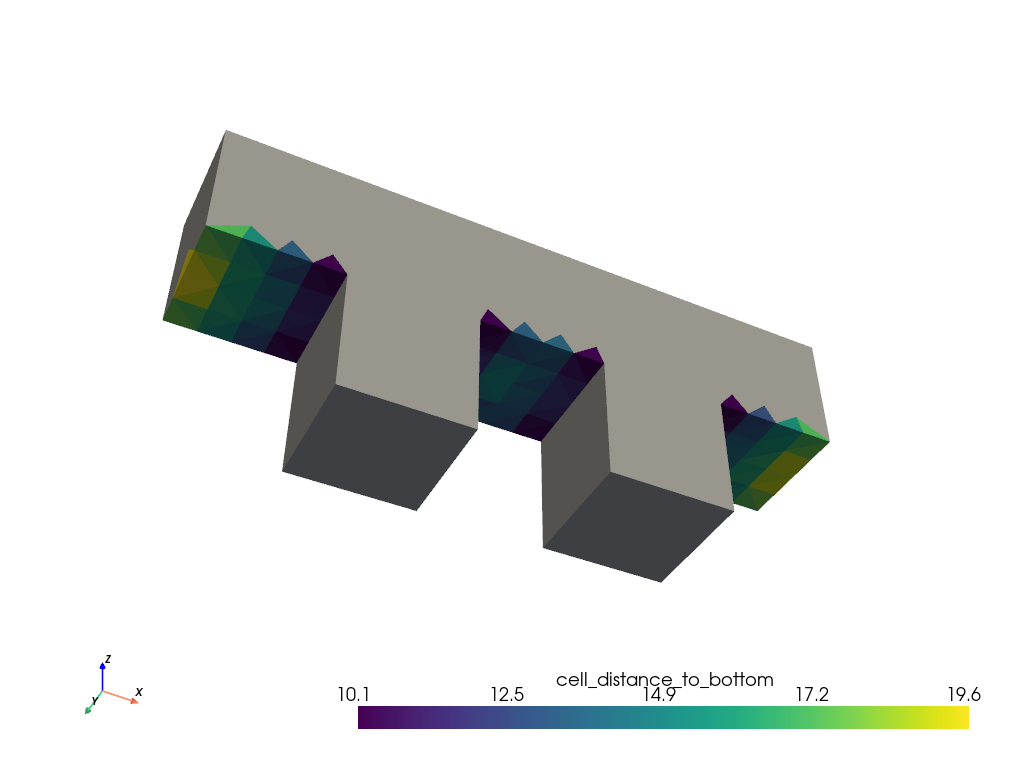

In [ ]:
# view the initial rotation field we are trying to optimize towards
# tet.extract_cells(tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)).plot(scalars="initial_rotation_field")
# tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)
# undeformed_tet.plot(scalars="initial_rotation_field")
# undeformed_tet.plot(scalars="in_air")
undeformed_tet.plot(scalars="cell_distance_to_bottom", cpos=[-0.5, -1, -1])
# undeformed_tet.plot(scalars="overhang_angle")
# undeformed_tet.plot(scalars="path_length_to_base_gradient")
# undeformed_tet.plot(scalars=new_tet1.cell_data['rotation_field'])

def show_path_to_base(tet, cell_index, plotter=pv.Plotter()):
    path_to_bottom = tet.cell_data['path_to_bottom'][cell_index]
    first_negative_index = np.where(path_to_bottom == -1)[0][0]
    path_to_bottom = path_to_bottom[:first_negative_index]
    print(path_to_bottom)

    for i in range(len(path_to_bottom)-1):
        path_to_base = pv.Line(tet.cell_data["cell_center"][path_to_bottom[i]], tet.cell_data["cell_center"][path_to_bottom[i+1]])
        plotter.add_mesh(path_to_base, color="red")

    plotter.add_mesh(tet, opacity=0.2)
    plotter.show()

# show_path_to_base(tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][7])

def show_path_to_base_gradient_calculation(tet, cell_indices):
    plotter = pv.Plotter()
    scalar = np.full(tet.number_of_cells, 0.0)

    for cell_index in cell_indices:
        local_cells = cell_neighbour_dict["edge"][cell_index]
        local_cells = np.hstack((local_cells, cell_index))
        local_cells_with_path_lengths = [x for x in local_cells if not np.isnan(tet.cell_data['cell_distance_to_bottom'][x])]
        path_lengths = tet.cell_data['cell_distance_to_bottom'][local_cells_with_path_lengths]

        cell_centers = tet.cell_data["cell_center"][local_cells_with_path_lengths]
        cell_centers_z_is_path_length = cell_centers.copy()
        cell_centers_z_is_path_length[:, 2] = path_lengths - np.min(path_lengths) + np.min(cell_centers[:, 2])
        points = pv.PolyData(cell_centers_z_is_path_length)
        glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.1))

        if len(cell_centers_z_is_path_length) < 3:
            continue

        p, n = planeFit(cell_centers_z_is_path_length.T)
        plane = pv.Plane(center=p, direction=n, i_size=4, j_size=4)
        normal_arrow = pv.Arrow(start=p, direction=n, scale=1.5)

        # reflect arrow across xy plane
        reflected_n = -n - 2 * (np.dot(-n, up_vector)) * up_vector

        # extract radial component
        cell_center_direction_normalized = tet.cell_data["cell_center"][cell_index, :2] / np.linalg.norm(tet.cell_data["cell_center"][cell_index, :2])
        gradient_in_radial_direction = np.dot(cell_center_direction_normalized, reflected_n[:2]) * cell_center_direction_normalized
        nozzle_arrow = pv.Arrow(start=tet.cell_data["cell_center"][cell_index], direction=np.hstack((gradient_in_radial_direction, reflected_n[2])), scale=1)


        # plotter.add_mesh(glyph, color="blue", opacity=0.5, )
        # plotter.add_mesh(plane, color="green", opacity=0.2)
        # plotter.add_mesh(normal_arrow, color="orange")
        plotter.add_mesh(nozzle_arrow, color="red")
    scalar[local_cells_with_path_lengths] = 0.5
    scalar[cell_index] = 1
    plotter.add_mesh(tet, opacity=0.2, scalars=scalar, cmap="binary")
    plotter.show()

# show_path_to_base_gradient_calculation(undeformed_tet, [np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][1]])
# show_path_to_base_gradient_calculation(undeformed_tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > np.deg2rad(90 + MAX_OVERHANG)))[0])

def show_dijkstras(tet, cell_index):
    plotter = pv.Plotter()#window_size=[3840, 2160])
    lines = []
    for neighbour in tet.field_data["cell_face_neighbours"]:
        lines += [tet.cell_data["cell_center"][neighbour[0]], tet.cell_data["cell_center"][neighbour[1]]]
    mesh = pv.line_segments_from_points(lines)
    plotter.add_mesh(mesh, color="grey", opacity=0.4)

    points = pv.PolyData(tet.cell_data["cell_center"])
    glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.1))
    plotter.add_mesh(glyph, color="red", opacity=0.2)

    if cell_index is None:
        plotter.show()
        return

    plotter.camera_position = "xz"

    # run dijkstra's algorithm and visualize
    plotter.open_gif(f'gifs/{model_name}_dijkstra.gif')
    distances, paths = nx.single_source_dijkstra(cell_neighbour_graph, cell_index)
    dijkstra_actors = []
    for i in np.arange(0, tet.cell_data['cell_distance_to_bottom'][cell_index], 0.2):
        nodes_in_range = [node for node, distance in distances.items() if distance < i]
        if len(nodes_in_range) == 0:
            continue
        if set(nodes_in_range) & set(bottom_cells):
            break
        points = pv.PolyData(tet.cell_data["cell_center"][nodes_in_range])
        glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.2))
        actor = plotter.add_mesh(glyph, color="blue", opacity=0.4)
        dijkstra_actors.append(actor)
        plotter.write_frame()


    path_to_bottom = tet.cell_data['path_to_bottom'][cell_index]
    first_negative_index = np.where(path_to_bottom == -1)[0][0]
    path_to_bottom = path_to_bottom[:first_negative_index]
    print(path_to_bottom)

    for i in range(len(path_to_bottom)-1):
        path_to_base = pv.Line(tet.cell_data["cell_center"][path_to_bottom[i]], tet.cell_data["cell_center"][path_to_bottom[i+1]])
        plotter.add_mesh(path_to_base, color="blue", line_width=5)

    for actor in dijkstra_actors:
        plotter.remove_actor(actor)

    plotter.write_frame()

    plotter.show()
    plotter.close()


# show_dijkstras(undeformed_tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][1])

In [ ]:
N = np.eye(4) - 1/4 * np.ones((4, 4)) # the N matrix centers the vertices of a tetrahedron around the origin

save_gif_i = 0

def calculate_deformation(tet, rotation_field_3d, ITERATIONS, SAVE_GIF):
    '''
    Try to find the optimal deformation of the tetrahedral mesh to make cells have the same rotation as
    the given rotation field.

    Our parameters are the vertices of the deformed mesh.
    rotation_field_3d: (N, 3) rotation vectors per cell
    '''

    new_vertices = tet.points.copy()

    params = new_vertices.flatten()

    rotation_matrices = calculate_rotation_matrices(tet, rotation_field_3d)

    # Extract old vertices for all cells
    old_vertices = tet.field_data["cell_vertices"][tet.field_data["cells"]]
    # Apply the transformation for all cells
    old_vertices_transformed = np.einsum('ijk,ikl->ijl', rotation_matrices, (N @ old_vertices).transpose(0, 2, 1))

    plotter = pv.Plotter(off_screen=True)

    if SAVE_GIF:
        plotter.open_gif(f'gifs/{model_name}_calculate_deformation.gif')

    def save_gif(new_vertices):
        global save_gif_i
        save_gif_i += 1

        if save_gif_i % 10 != 0:
            return

        new_tet = pv.UnstructuredGrid(tet.cells, np.full(tet.number_of_cells, pv.CellType.TETRA), new_vertices)
        mesh_actor = plotter.add_mesh(new_tet)
        plotter.write_frame()
        plotter.remove_actor(mesh_actor)


    def objective_function(params):
        start_time = time.time()

        new_vertices = params[:tet.number_of_points * 3].reshape(-1, 3)

        if SAVE_GIF:
            save_gif(new_vertices)

        # Apply transformation for the new vertices
        new_vertices_transformed = (N @ new_vertices[tet.field_data["cells"]]).transpose(0, 2, 1)

        # Calculate position compatibility loss using vectorized operations
        position_losses = np.linalg.norm(new_vertices_transformed - old_vertices_transformed, axis=(1, 2))**2

        return position_losses

    def objective_jacobian(params):
        start_time = time.time()

        # Initialize Jacobian matrix
        J = lil_matrix((tet.number_of_cells, len(params)), dtype=np.float32)

        # Extract parameters
        new_vertices = params[:tet.number_of_points * 3].reshape(-1, 3)

        # Extract old vertices for all cells
        old_vertices = tet.field_data["cell_vertices"][tet.field_data["cells"]]

        # Apply the transformation for old and new vertices
        new_vertices_transformed = (N @ new_vertices[tet.field_data["cells"]]).transpose(0, 2, 1)

        # Compute the difference between transformed new and old vertices
        diff = new_vertices_transformed - old_vertices_transformed  # shape: (num_cells, 3, num_vertices_per_cell)

        # Reshape diff for easier broadcasting
        diff = diff.transpose(0, 2, 1)  # shape: (num_cells, num_vertices_per_cell, 3)

        # Now, for each cell, update the corresponding rows in the Jacobian
        cell_indices = np.repeat(np.arange(tet.number_of_cells), len(tet.field_data["cells"][0]))  # Cell indices repeated per vertex
        vertex_indices = np.ravel(tet.field_data["cells"])  # Flatten the cell-to-vertex mapping

        # For each component x, y, z in the vertex, update the Jacobian
        for dim in range(3):
            J[cell_indices, vertex_indices * 3 + dim] = 2 * diff[:, :, dim].ravel()

        return J.tocsr()

    def jac_sparsity():
        sparsity = lil_matrix((tet.number_of_cells, len(params)), dtype=np.int8)

        cell_indices = np.repeat(np.arange(tet.number_of_cells), len(tet.field_data["cells"][0]))
        vertex_indices = np.ravel(tet.field_data["cells"])

        for dim in range(3):
            sparsity[cell_indices, vertex_indices * 3 + dim] = 1

        return sparsity.tocsr()

    result = least_squares(objective_function,
                    params,
                    max_nfev=ITERATIONS,
                    verbose=2,
                    jac=objective_jacobian,
                    jac_sparsity=jac_sparsity(),
                    method='trf',
                    x_scale='jac',
                    )

    plotter.close()

    return result.x[:tet.number_of_points*3].reshape(-1, 3)

ITERATIONS = 1000
SAVE_GIF = True
new_vertices = calculate_deformation(undeformed_tet, rotation_field_3d, ITERATIONS, SAVE_GIF)
deformed_tet = pv.UnstructuredGrid(undeformed_tet.cells, np.full(undeformed_tet.number_of_cells, pv.CellType.TETRA), new_vertices)
deformed_tet.plot()

for key in undeformed_tet.field_data.keys():
    deformed_tet.field_data[key] = undeformed_tet.field_data[key]
for key in undeformed_tet.cell_data.keys():
    deformed_tet.cell_data[key] = undeformed_tet.cell_data[key]
deformed_tet = update_tet_attributes(deformed_tet)


Run below to do another iteration

In [10]:
undeformed_tet = deformed_tet.copy()

Run below when finished deforming to save mesh as STL

In [12]:
# make origin center bottom of bounding box
x_min, x_max, y_min, y_max, z_min, z_max = deformed_tet.bounds
offsets_applied = np.array([(x_min + x_max) / 2, (y_min + y_max) / 2, z_min])
deformed_tet.points -= offsets_applied

deformed_tet.extract_surface().save(f'output_models/{model_name}_deformed_tet.stl')

In [15]:

# save to pickle
with open(f'pickle_files/deformed_{model_name}.pkl', 'wb') as f:
    pickle.dump(deformed_tet, f)

# Now, go and slice the stl file in Cura!

Settings:
- Make the printer origin at the center of the buildplate
- Dont use any pre/post scripts, z hop, etc. The config I use is provided in the github repo
- Autoplace the model at the center by clicking "Arrange All Models"

In [16]:

deformed_tet = pickle.load(open(f'pickle_files/deformed_{model_name}.pkl', 'rb'))

In [17]:
def tetrahedron_volume(p1, p2, p3, p4):
    '''
    Calculate the volume of the tetrahedron formed by four points
    '''

    mat = np.vstack([p2 - p1, p3 - p1, p4 - p1])
    return np.abs(np.linalg.det(mat)) / 6

def calc_barycentric_coordinates(tet_a, tet_b, tet_c, tet_d, point):
    '''
    Calculate the barycentric coordinates of a point in a tetrahedron. This is used to interpolate
    parameters from the vertices of the tetrahedron to a point within the tetrhedron.
    '''

    total_volume = tetrahedron_volume(tet_a, tet_b, tet_c, tet_d)

    if total_volume == 0:
        raise ValueError("The points do not form a valid tetrahedron (zero volume).")

    # Calculate the sub-volumes for each face
    vol_a = tetrahedron_volume(point, tet_b, tet_c, tet_d)
    vol_b = tetrahedron_volume(point, tet_a, tet_c, tet_d)
    vol_c = tetrahedron_volume(point, tet_a, tet_b, tet_d)
    vol_d = tetrahedron_volume(point, tet_a, tet_b, tet_c)

    # Calculate barycentric coordinates as the ratio of sub-volumes to total volume
    lambda_a = vol_a / total_volume
    lambda_b = vol_b / total_volume
    lambda_c = vol_c / total_volume
    lambda_d = vol_d / total_volume

    # The barycentric coordinates should sum to 1
    return np.array([lambda_a, lambda_b, lambda_c, lambda_d])

def project_point_onto_plane(plane_x_axis, plane_y_axis, point):
    projected_x = np.sum(plane_x_axis * point, axis=1)
    projected_y = np.sum(plane_y_axis * point, axis=1)

    return np.array([projected_x, projected_y]).T

In [18]:
deformed_tet, _, _ = calculate_tet_attributes(deformed_tet)

In [ ]:
from pygcode import Line
import time

SEG_SIZE = 0.6 # mm

# 5-axis CoreXYBC parameters
BED_OFFSET = 30.0      # mm, distance from B-axis rotation center to bed surface
B_MAX = 90             # degrees, max B-axis angle
B_MIN = -90            # degrees, min B-axis angle
LOW_Z_THRESHOLD = 100  # mm, below this Z height, B limit is stricter
B_MAX_LOW_Z = 45       # degrees, B limit when Z < LOW_Z_THRESHOLD
C_MAX = 180            # degrees, max C-axis angle
C_MIN = -180           # degrees, min C-axis angle
B_MAX_DELTA = np.deg2rad(1)   # max B change per segment (radians)
C_MAX_DELTA = np.deg2rad(2)   # max C change per segment (radians)
B_AVERAGING_ALPHA = 0.2  # EMA smoothing factor for B
C_AVERAGING_ALPHA = 0.2  # EMA smoothing factor for C
MAX_EXTRUSION_MULTIPLIER = 10
RETRACTION_LENGTH = 1.0
ENABLE_RTCP = True  # apply trunnion kinematics compensation in slicer

def decompose_rotation_to_BC(rotation_matrix):
    """Decompose 3x3 rotation matrix into B (Y-axis tilt) and C (Z-axis rotation) angles.
    Assumes R ≈ R_y(B) @ R_z(C):
      [[cB*cC, -cB*sC, sB],
       [sC,     cC,     0 ],
       [-sB*cC, sB*sC,  cB]]
    Returns (B, C) in radians.
    """
    B = np.arctan2(rotation_matrix[0, 2], rotation_matrix[2, 2])
    C = np.arctan2(rotation_matrix[1, 0], rotation_matrix[1, 1])
    return B, C

# find how each vertex in tet has been transformed
vertex_transformations = deformed_tet.points - input_tet.points

# calculate rotation for each vertex and cell using 3D Kabsch algorithm
num_cells_per_vertex = np.zeros((input_tet.number_of_points))
for cell_index, cell in enumerate(input_tet.field_data["cells"]):
    num_cells_per_vertex[cell] += 1

vertex_rotvecs = np.zeros((deformed_tet.number_of_points, 3))
cell_rotvecs = np.zeros((deformed_tet.number_of_cells, 3))
cell_rotations_B = np.zeros((deformed_tet.number_of_cells))
cell_rotations_C = np.zeros((deformed_tet.number_of_cells))

for cell_index, cell in enumerate(deformed_tet.field_data["cells"]):
    new_vertices = deformed_tet.field_data["cell_vertices"][cell].copy()
    new_cell_center = deformed_tet.cell_data["cell_center"][cell_index]
    old_vertices = input_tet.field_data["cell_vertices"][cell].copy()
    old_cell_center = input_tet.cell_data["cell_center"][cell_index]

    # center points around cell centers
    new_vertices -= new_cell_center
    old_vertices -= old_cell_center

    # 3D Kabsch algorithm
    H = new_vertices.T @ old_vertices  # (3, 3)
    U, S, Vt = np.linalg.svd(H)
    d = np.linalg.det(U @ Vt)
    sign_matrix = np.diag([1, 1, np.sign(d)])
    rotation_matrix_3x3 = U @ sign_matrix @ Vt

    # Decompose to B, C
    B_angle, C_angle = decompose_rotation_to_BC(rotation_matrix_3x3)

    # Joint limits based on Z height
    z_height = input_tet.cell_data["cell_center"][cell_index, 2]
    b_limit = np.deg2rad(B_MAX_LOW_Z) if z_height < LOW_Z_THRESHOLD else np.deg2rad(B_MAX)
    B_angle = np.clip(B_angle, -b_limit, b_limit)
    C_angle = np.clip(C_angle, np.deg2rad(C_MIN), np.deg2rad(C_MAX))

    # Gimbal lock warning
    if abs(B_angle) > np.deg2rad(85):
        print(f"Warning: B angle near gimbal lock ({np.rad2deg(B_angle):.1f}deg) at cell {cell_index}")

    cell_rotations_B[cell_index] = B_angle
    cell_rotations_C[cell_index] = C_angle

    # Reconstruct rotation vector from clipped B, C (intrinsic yz = R_y(B) @ R_z(C))
    Ry = R.from_euler('y', B_angle).as_matrix()
    Rz = R.from_euler('z', C_angle).as_matrix()
    cell_rotvecs[cell_index] = R.from_matrix(Ry @ Rz).as_rotvec()

    for vertex_index in cell:
        vertex_rotvecs[vertex_index] += cell_rotvecs[cell_index] / num_cells_per_vertex[vertex_index]

# calculate z squish scale for each cell (ratio of original volume to deformed volume)
tet_rotation_matrices = calculate_rotation_matrices(input_tet, cell_rotvecs)
z_squish_scales = np.full((deformed_tet.number_of_cells), np.nan)
for cell_index, cell in enumerate(deformed_tet.field_data["cells"]):
    warped_vertices = deformed_tet.field_data["cell_vertices"][cell]
    unwarped_vertices = input_tet.field_data["cell_vertices"][cell]

    # rotate new vertices to align with old vertices
    unwarped_vertices_rotated = (tet_rotation_matrices[cell_index].reshape(1, 3, 3) @ unwarped_vertices.reshape(4, 3, 1)).reshape(4, 3)

    z_squish_scales[cell_index] = tetrahedron_volume(*unwarped_vertices) / tetrahedron_volume(*warped_vertices)


# read gcode
pos = np.array([0., 0., 20.])
feed = 5000
gcode_points = []
with open(f'input_gcode/{model_name}_deformed_tet.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text)

        if not line.block.gcodes:
            continue

        for gcode in sorted(line.block.gcodes):
            if gcode.word == "G01" or gcode.word == "G00":
                prev_pos = pos.copy()

                if gcode.X is not None:
                    pos[0] = gcode.X
                if gcode.Y is not None:
                    pos[1] = gcode.Y
                if gcode.Z is not None:
                    pos[2] = gcode.Z

                # extract feed
                for word in line.block.words:
                    if word.letter == "F":
                        feed = word.value

                # extract extrusion
                extrusion = None
                for param in line.block.modal_params:
                    if param.letter == "E":
                        extrusion = param.value

                # segment moves
                delta_pos = pos - prev_pos
                distance = np.linalg.norm(delta_pos)
                if distance > 0:
                    num_segments = -(-distance // SEG_SIZE) # hacky round up
                    seg_distance = distance/num_segments

                    for i in range(int(num_segments)):
                        gcode_points.append({
                            "position": (prev_pos + delta_pos * (i+1) / num_segments),
                            "command": gcode.word,
                            "extrusion": extrusion/num_segments if extrusion is not None else None,
                            "move_length": seg_distance,
                            "start_position": prev_pos,
                            "end_position": pos,
                            "unsegmented_move_length": distance,
                            "after_retract": False,
                            "feed": feed
                        })
                else:
                    gcode_points.append({
                        "position": pos.copy(),
                        "command": gcode.word,
                        "extrusion": extrusion,
                        "move_length": distance,
                        "unsegmented_move_length": distance,
                        "after_retract": False,
                        "feed": feed
                    })

# calculate containing cell for each gcode point
gcode_points_containing_cells = deformed_tet.find_containing_cell([point["position"] for point in gcode_points])

# for cells with no containing cell, find the closest cell
gcode_points_closest_cells = deformed_tet.find_closest_cell([point["position"] for point in gcode_points])

# transform gcode points to original mesh's shape with B,C rotation
new_gcode_points = []
prev_new_position = None
travelling_over_air = False
travelling = False
prev_B = 0.0
prev_C = 0.0
prev_travelling = False
prev_command = "G00"
lost_vertices = []
highest_printed_point = 0

for cell_index, (gcode_point, containing_cell_index) in enumerate(zip(gcode_points, gcode_points_containing_cells)):
    position = gcode_point["position"]
    command = gcode_point["command"]
    extrusion = gcode_point["extrusion"]

    def barycentric_interpolate_to_get_new_position_and_BC(position, containing_cell_index, command, cell_index):
        if command == "G00" and containing_cell_index == -1:
            return None, None, None
        if command == "G01" and containing_cell_index == -1:
            containing_cell_index = gcode_points_closest_cells[cell_index]

        # get barycentric coordinates of pos in containing cell
        vertex_indices = deformed_tet.field_data["cells"][containing_cell_index]
        cell_vertices = deformed_tet.field_data["cell_vertices"][vertex_indices]
        barycentric_coordinates = calc_barycentric_coordinates(cell_vertices[0], cell_vertices[1], cell_vertices[2], cell_vertices[3], position)

        if np.sum(barycentric_coordinates) > 1.01:
            return None, None, None

        # calculate the new position using barycentric interpolation of vertex transformations
        transformation = vertex_transformations[vertex_indices] * barycentric_coordinates[:, None]
        transformation = np.sum(transformation, axis=0)
        new_position = position - transformation

        # interpolate rotation vector using barycentric coordinates
        rotvec = np.sum(vertex_rotvecs[vertex_indices] * barycentric_coordinates[:, None], axis=0)
        rot_mat = R.from_rotvec(rotvec).as_matrix()
        B_angle, C_angle = decompose_rotation_to_BC(rot_mat)

        return new_position, B_angle, C_angle

    dont_smooth = False
    new_position, B_angle, C_angle = barycentric_interpolate_to_get_new_position_and_BC(position, containing_cell_index, command, cell_index)

    if new_position is None:
        if command == "G01":
            lost_vertices.append(position)
            continue
        elif command == "G00" and not travelling_over_air and prev_new_position is not None:
            new_position = np.array([prev_new_position[0], prev_new_position[1], highest_printed_point])
            B_angle = np.clip(prev_B, np.deg2rad(-45), np.deg2rad(45))
            C_angle = prev_C
            dont_smooth = True
            travelling_over_air = True
        elif travelling_over_air:
            continue
        else:
            continue
    else:
        if travelling_over_air:
            new_position[2] = highest_printed_point
            B_angle = np.clip(B_angle, np.deg2rad(-45), np.deg2rad(45))
            dont_smooth = True
        travelling_over_air = False

    extrusion_multiplier = 1
    if extrusion is not None and extrusion != RETRACTION_LENGTH and extrusion != -RETRACTION_LENGTH:
        extrusion_multiplier = extrusion_multiplier * z_squish_scales[containing_cell_index]
        extrusion = extrusion * min(extrusion_multiplier, MAX_EXTRUSION_MULTIPLIER)
    elif extrusion == -RETRACTION_LENGTH:
        travelling = True
    elif extrusion == RETRACTION_LENGTH:
        travelling = False

    # EMA smoothing for B and C (independently)
    if not dont_smooth:
        B_angle = B_AVERAGING_ALPHA * B_angle + (1 - B_AVERAGING_ALPHA) * prev_B

        # C smoothing with wrapping at +/-pi
        delta_C_smooth = C_angle - prev_C
        if delta_C_smooth > np.pi:
            delta_C_smooth -= 2 * np.pi
        elif delta_C_smooth < -np.pi:
            delta_C_smooth += 2 * np.pi
        C_angle = prev_C + C_AVERAGING_ALPHA * delta_C_smooth

    # Rate limiting: if B or C change exceeds max delta, insert interpolation points
    delta_B = B_angle - prev_B
    delta_C = C_angle - prev_C
    # C wrapping for rate limit check
    if delta_C > np.pi:
        delta_C -= 2 * np.pi
    elif delta_C < -np.pi:
        delta_C += 2 * np.pi

    max_delta_ratio = max(
        abs(delta_B) / B_MAX_DELTA if B_MAX_DELTA > 0 else 0,
        abs(delta_C) / C_MAX_DELTA if C_MAX_DELTA > 0 else 0
    )

    if prev_new_position is not None and max_delta_ratio > 1:
        num_interpolations = int(max_delta_ratio) + 1
        delta_pos = new_position - prev_new_position
        for i in range(num_interpolations):
            t = (i + 1) / num_interpolations
            new_gcode_points.append({
                "position": prev_new_position + delta_pos * t,
                "original_position": position,
                "B": prev_B + delta_B * t,
                "C": prev_C + delta_C * t,
                "command": prev_command,
                "extrusion": extrusion / num_interpolations if extrusion is not None else None,
                "extrusion_multiplier": extrusion_multiplier,
                "feed": gcode_point["feed"],
                "travelling": prev_travelling
            })
    else:
        new_gcode_points.append({
            "position": new_position,
            "original_position": position,
            "B": B_angle,
            "C": C_angle,
            "command": command,
            "extrusion": extrusion,
            "extrusion_multiplier": extrusion_multiplier,
            "feed": gcode_point["feed"],
            "travelling": travelling
        })

    prev_B = B_angle
    prev_C = C_angle
    prev_new_position = new_position.copy()
    prev_travelling = travelling
    prev_command = command

    if command == "G01" and extrusion is not None and extrusion > 0 and (highest_printed_point != 0 or new_position[2] < 1):
        highest_printed_point = max(highest_printed_point, new_position[2])


print(f"Lost {len(lost_vertices)} vertices")


In [ ]:

def trunnion_forward_kinematics(P_workpiece, B_rad, C_rad, bed_offset):
    """Transform workpiece coordinates to machine coordinates for trunnion table.
    Kinematic chain: Base -> R_y(B) -> R_z(C) -> workpiece
    B-axis pivot is bed_offset above the bed surface.
    When B=0, C=0, returns P_workpiece unchanged (identity).
    """
    # Shift to B-axis pivot frame (pivot is bed_offset above bed surface)
    P_shifted = P_workpiece.copy()
    P_shifted[2] -= bed_offset

    # Apply C rotation (inner, around Z)
    Rz = R.from_euler('z', C_rad).as_matrix()
    P_after_C = Rz @ P_shifted

    # Apply B rotation (outer, around Y)
    Ry = R.from_euler('y', B_rad).as_matrix()
    P_after_B = Ry @ P_after_C

    # Shift back to machine frame
    return P_after_B + np.array([0, 0, bed_offset])

# save transformed gcode as Cartesian X Y Z B C
start_z = 50  # safe start height

with open(f'output_gcode/{model_name}.gcode', 'w') as fh:
    fh.write("G90 ; absolute positioning\n")
    fh.write("G21 ; mm units\n")
    fh.write("G28 ; home all axes\n")
    fh.write("M83 ; relative extrusion\n")
    fh.write("G1 E10 F200 ; prime extruder\n")
    fh.write("G94 ; mm/min feed rate mode\n")
    fh.write(f"G0 X0 Y0 Z{start_z} B0 C0 F5000\n")

    for i, point in enumerate(new_gcode_points):
        position = point["position"]
        B_rad = point["B"]
        C_rad = point["C"]

        if np.any(np.isnan(position)):
            continue

        if position[2] < 0:
            continue

        # Apply trunnion kinematics compensation
        wp = position.copy()
        if ENABLE_RTCP:
            machine_pos = trunnion_forward_kinematics(wp, B_rad, C_rad, BED_OFFSET)
        else:
            machine_pos = wp.copy()

        # Z-hop for travel moves (in machine space)
        if point["travelling"]:
            machine_pos[2] += 1.0

        string = f"{point['command']} X{machine_pos[0]:.4f} Y{machine_pos[1]:.4f} Z{machine_pos[2]:.4f}"
        string += f" B{np.rad2deg(B_rad):.4f} C{np.rad2deg(C_rad):.4f}"

        if point["extrusion"] is not None:
            string += f" E{point['extrusion']:.4f}"

        string += f" F{point['feed']}"

        fh.write(string + "\n")


In [ ]:
# plot new_gcode_points using pyvista
temp = np.array([point["position"] for point in new_gcode_points])
temp = pv.PolyData(temp)
temp.cell_data["B"] = np.array([np.rad2deg(point["B"]) for point in new_gcode_points])
temp.cell_data["C"] = np.array([np.rad2deg(point["C"]) for point in new_gcode_points])
temp.cell_data["travelling"] = np.array([point["travelling"] for point in new_gcode_points])
temp.cell_data["delta_B"] = np.clip(np.array([0] + [np.rad2deg(new_gcode_points[i+1]["B"] - new_gcode_points[i]["B"]) for i in range(len(new_gcode_points)-1)]), -10, 10)
temp.cell_data["delta_C"] = np.clip(np.array([0] + [np.rad2deg(new_gcode_points[i+1]["C"] - new_gcode_points[i]["C"]) for i in range(len(new_gcode_points)-1)]), -10, 10)
temp.cell_data["command"] = np.array([point["command"] for point in new_gcode_points])
temp.cell_data["feed"] = np.array([min(point["feed"], 10000) for point in new_gcode_points])
temp.cell_data["original_z"] = np.array([point["original_position"][2] for point in new_gcode_points])
temp.cell_data["original_z_bands"] = temp.cell_data["original_z"] % 1
temp.cell_data["extrusion_multiplier"] = np.array([min(point["extrusion_multiplier"], 15) if point["extrusion_multiplier"] is not None else np.nan for point in new_gcode_points])

temp.extract_cells(np.array([point["command"] for point in new_gcode_points]) == "G01").plot(scalars="original_z_bands", cpos=[-0.5, -1, 0.5], point_size=10)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the gcode with B angle coloring
fig = plt.figure(figsize=(15, 5))

# 3D trajectory plot colored by B angle
ax1 = fig.add_subplot(131, projection='3d')
g01_indices = np.where(temp.cell_data["command"] == "G01")[0]
g00_indices = np.where(temp.cell_data["command"] == "G00")[0]

cmap = plt.get_cmap('coolwarm')
B_vals = temp.cell_data["B"]
B_max_abs = max(np.max(np.abs(B_vals[g01_indices])), 1e-6)
B_normalized = (B_vals[g01_indices] / B_max_abs + 1) / 2  # map to [0, 1]
colors = cmap(B_normalized)

ax1.scatter(temp.points[g01_indices,0], temp.points[g01_indices,1], temp.points[g01_indices,2],
           c=colors, s=0.3, alpha=0.5)
ax1.plot(temp.points[g00_indices,0], temp.points[g00_indices,1], temp.points[g00_indices,2],
        markersize=0.2, linewidth=0.1, marker=".", alpha=0.3, color="gray")
ax1.set_box_aspect((np.ptp(temp.points[:,0]), np.ptp(temp.points[:,1]), np.ptp(temp.points[:,2])))
ax1.set_title('Trajectory (color=B angle)')

# B angle distribution
ax2 = fig.add_subplot(132)
ax2.hist(temp.cell_data["B"][g01_indices], bins=50, color='steelblue', alpha=0.7)
ax2.set_xlabel('B angle (deg)')
ax2.set_ylabel('Count')
ax2.set_title('B angle distribution')

# C angle distribution
ax3 = fig.add_subplot(133)
ax3.hist(temp.cell_data["C"][g01_indices], bins=50, color='coral', alpha=0.7)
ax3.set_xlabel('C angle (deg)')
ax3.set_ylabel('Count')
ax3.set_title('C angle distribution')

plt.tight_layout()
plt.show()
